In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import datetime

In [ ]:
file_loc='/content/Cleaned_dataset.xlsx'

df_sarima = pd.read_excel(file_loc)

df_sarima.head()

,settlement_date,settlement_period,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,...,east_west_flow,nemo_flow,nsl_flow,eleclink_flow,scottish_transfer,viking_flow,is_holiday,year,renewable_generation,Imp_Exp_flow
0,2009-01-01,1,37910,38704.0,33939,54,1403,0,0,0,...,0,0,0,0,0,0,1,2009,54,1841
1,2009-01-01,2,38047,38964.0,34072,53,1403,0,0,0,...,0,0,0,0,0,0,1,2009,53,1842
2,2009-01-01,3,37380,38651.0,33615,53,1403,0,0,0,...,0,0,0,0,0,0,1,2009,53,1842
3,2009-01-01,4,36426,37775.0,32526,50,1403,0,0,0,...,0,0,0,0,0,0,1,2009,50,1612
4,2009-01-01,5,35687,37298.0,31877,50,1403,0,0,0,...,0,0,0,0,0,0,1,2009,50,1593


Setting up the DataFrame

In [ ]:
# Assuming 'date' is the column with datetime values; ensure it's in datetime format
df_sarima['settlement_date'] = pd.to_datetime(df_sarima['settlement_date'])

# Set the datetime column as the index
df_sarima.set_index('settlement_date', inplace=True)

# Now you can resample
df_sarima = df_sarima["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year


In [ ]:
# Check the first few rows to confirm changes
df_sarima.head()

,tsd,month,year
settlement_date,,,
2009-01-01,1849363.0,1,2009
2009-01-02,1974406.0,1,2009
2009-01-03,1952054.0,1,2009
2009-01-04,1968670.0,1,2009
2009-01-05,2271471.0,1,2009


Plotting Daily Electricity Demand

<Axes: title={'center': 'Daily total electricity demand'}, xlabel='settlement_date', ylabel='Total electricity demand (MW)'>

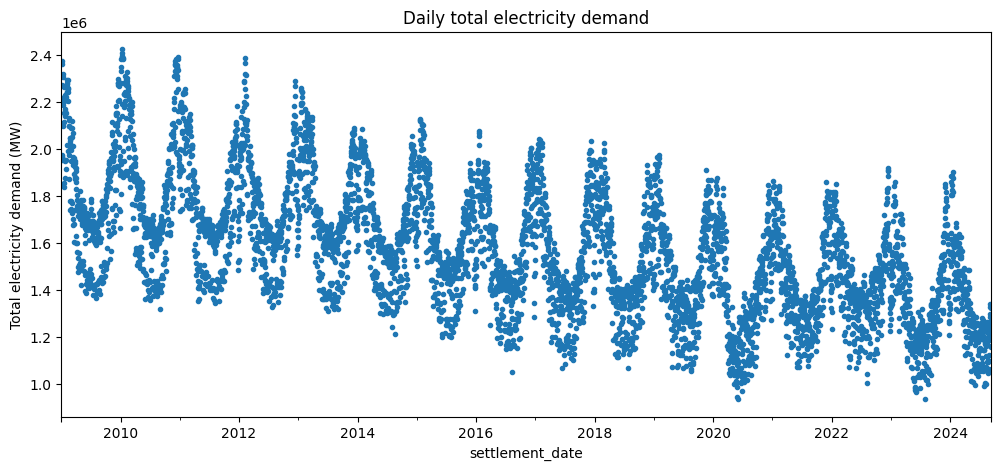

In [ ]:
df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
)


Handling Missing Values

In [ ]:
# This creates a boolean mask where True indicates a missing value in the 'tsd' column
is_null = df_sarima['tsd'].isna()

# Now, use this mask to find the days which have null values
null_days = df_sarima[is_null].index


In [ ]:
null_info = zip(
    df_sarima.loc[null_days].index.month, df_sarima.loc[null_days].index.year
)

mean_values = [
    df_sarima.loc[
        (df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"
    ].mean()
    for info in null_info
]

df_sarima.loc[null_days, "tsd"] = mean_values


Creating Lag Features

In [ ]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


Create Lag Columns

In [ ]:
# Creating lag columns for one day and one year prior
df_sarima['lag_day'] = df_sarima['tsd'].shift(1)
df_sarima['lag_year'] = df_sarima['tsd'].shift(364)  # Adjust according to your data's exact yearly lag


Calculating Differences

In [ ]:
# Calculating daily and yearly differences
df_sarima['difference_day'] = df_sarima['tsd'] - df_sarima['lag_day']
df_sarima['difference_year'] = df_sarima['tsd'] - df_sarima['lag_year']


Verify Column Creation

In [ ]:
# Print the head of the DataFrame to verify the new columns are there
print(df_sarima.head())


                       tsd  month  year    lag_day  lag_year  difference_day  \
settlement_date                                                                
2009-01-01       1849363.0      1  2009        NaN       NaN             NaN   
2009-01-02       1974406.0      1  2009  1849363.0       NaN        125043.0   
2009-01-03       1952054.0      1  2009  1974406.0       NaN        -22352.0   
2009-01-04       1968670.0      1  2009  1952054.0       NaN         16616.0   
2009-01-05       2271471.0      1  2009  1968670.0       NaN        302801.0   

                 difference_year  
settlement_date                   
2009-01-01                   NaN  
2009-01-02                   NaN  
2009-01-03                   NaN  
2009-01-04                   NaN  
2009-01-05                   NaN  


Plot the Data

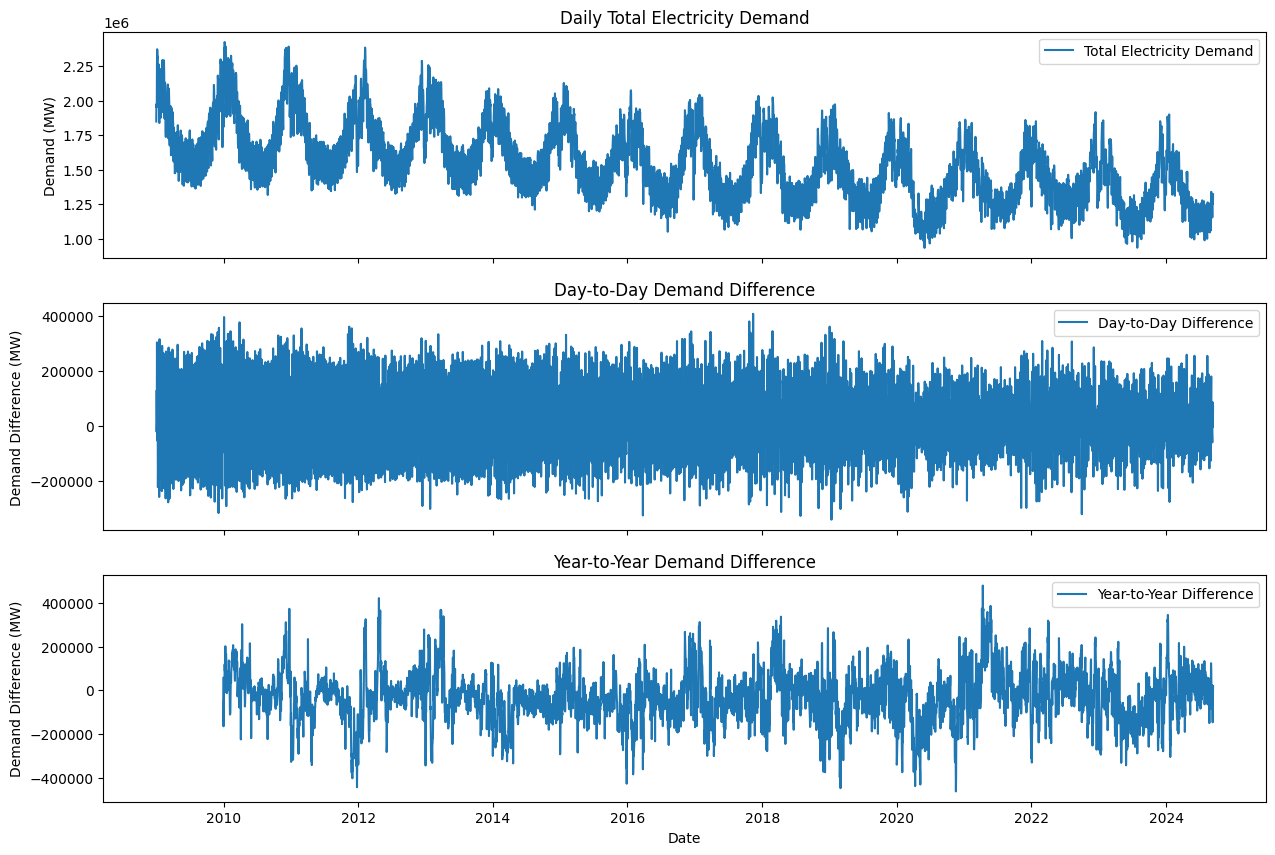

In [ ]:
# Plotting the original data and differences
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes[0].plot(df_sarima.index, df_sarima['tsd'], label='Total Electricity Demand')
axes[1].plot(df_sarima.index, df_sarima['difference_day'], label='Day-to-Day Difference')
axes[2].plot(df_sarima.index, df_sarima['difference_year'], label='Year-to-Year Difference')

# Adding labels and titles
axes[0].set_ylabel('Demand (MW)')
axes[0].set_title('Daily Total Electricity Demand')
axes[1].set_ylabel('Demand Difference (MW)')
axes[1].set_title('Day-to-Day Demand Difference')
axes[2].set_ylabel('Demand Difference (MW)')
axes[2].set_title('Year-to-Year Demand Difference')
axes[2].set_xlabel('Date')

# Adding legends
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Show the plot
plt.show()


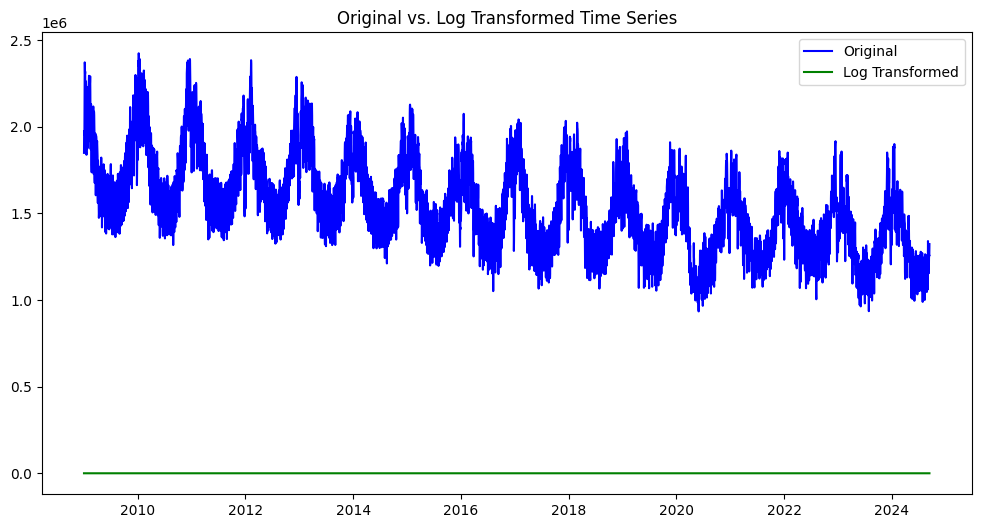

In [ ]:
# Apply log transformation to the 'tsd' column
df_sarima['log_tsd'] = np.log(df_sarima['tsd'])

# Plot the original and log-transformed series
plt.figure(figsize=(12, 6))
plt.plot(df_sarima['tsd'], label='Original', color='blue')
plt.plot(df_sarima['log_tsd'], label='Log Transformed', color='green')
plt.title('Original vs. Log Transformed Time Series')
plt.legend(loc='best')
plt.show()


Stationarity Testing

Results of Dickey-Fuller Test:
Test Statistic                   -3.276410
p-value                           0.015966
#Lags Used                       34.000000
Number of Observations Used    5699.000000
Critical Value (1%)              -3.431498
Critical Value (5%)              -2.862047
Critical Value (10%)             -2.567040
dtype: float64


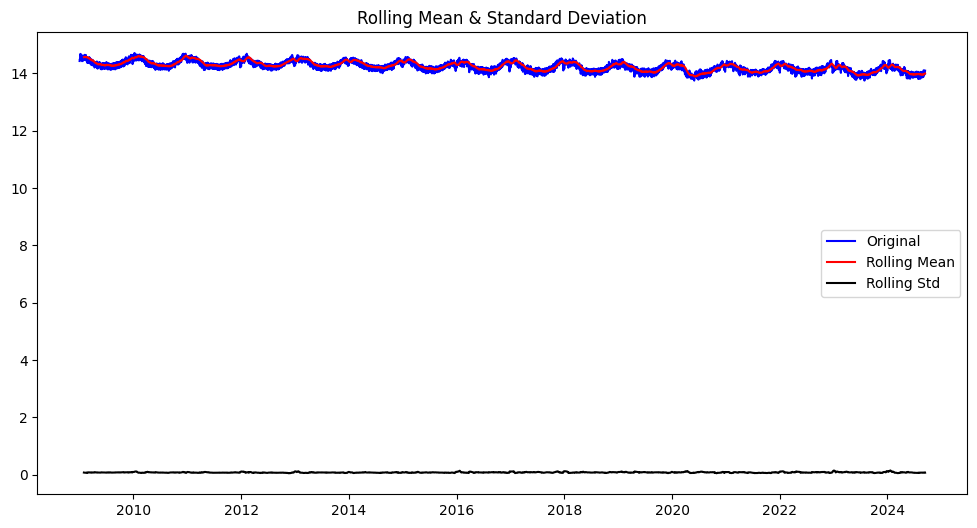

In [ ]:
def dftest(timeseries, window_size):
     # Performing the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in result[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    # Printing the results
    print('Results of Dickey-Fuller Test:')
    print(dfoutput)

    # Determining rolling statistics
    rolling_mean = timeseries.rolling(window=window_size).mean()
    rolling_std = timeseries.rolling(window=window_size).std()

    # Plotting rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# Now you can call your defined function
dftest(df_sarima['log_tsd'], 30)



Decomposing the Series

<ipython-input-16-4482caee4baf>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_sarima['log_tsd'] = df_sarima['log_tsd'].fillna(method='ffill')  # Forward fill as an example; adjust as needed


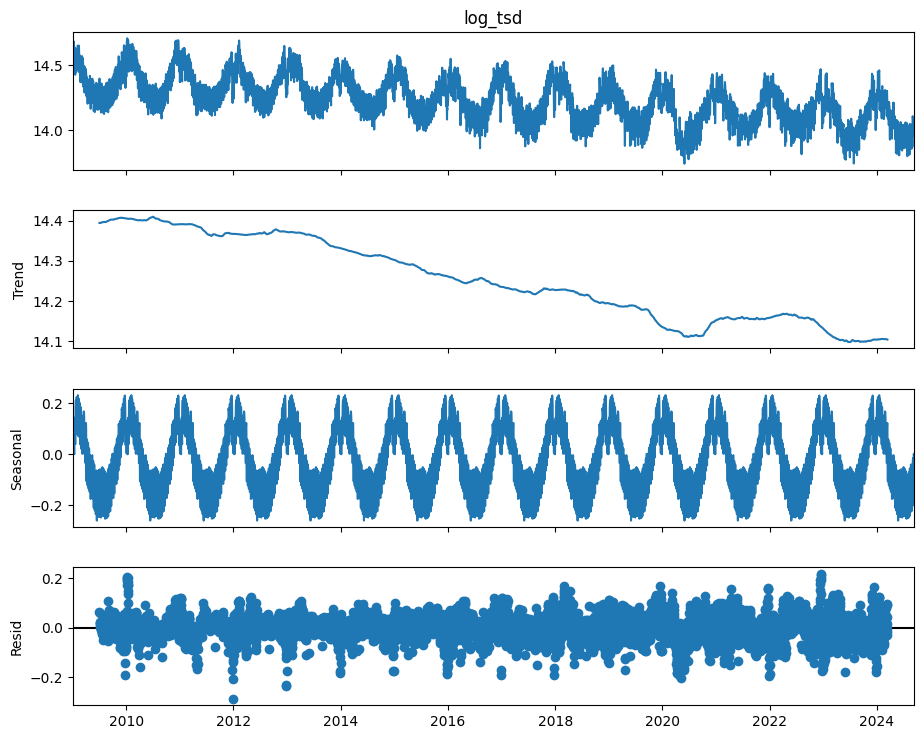

In [ ]:


# Make sure your time series data is correctly formatted and non-null values are handled
df_sarima['log_tsd'] = df_sarima['log_tsd'].fillna(method='ffill')  # Forward fill as an example; adjust as needed

# Perform the decomposition
decompose = seasonal_decompose(df_sarima['log_tsd'], period=364)  # Adjust the period according to your data's seasonality
fig = decompose.plot()
fig.set_size_inches(10, 8)  # Optionally adjust figure size
plt.show()  # Ensure the plot is displayed


More Detailed Analysis

In [ ]:
def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):

    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    raw.set_title('Raw Data')
    plot_acf(data, lags=lags_1, ax=acf_1)
    plot_pacf(data, lags=lags_1, ax=pacf_1)
    plot_acf(data, lags=lags_2, ax=acf_2)
    plot_pacf(data, lags=lags_2, ax=pacf_2)
    plt.tight_layout()


Results of Dickey-Fuller Test:
Test Statistic                   -5.113152
p-value                           0.000013
#Lags Used                       34.000000
Number of Observations Used    5699.000000
Critical Value (1%)              -3.431498
Critical Value (5%)              -2.862047
Critical Value (10%)             -2.567040
dtype: float64


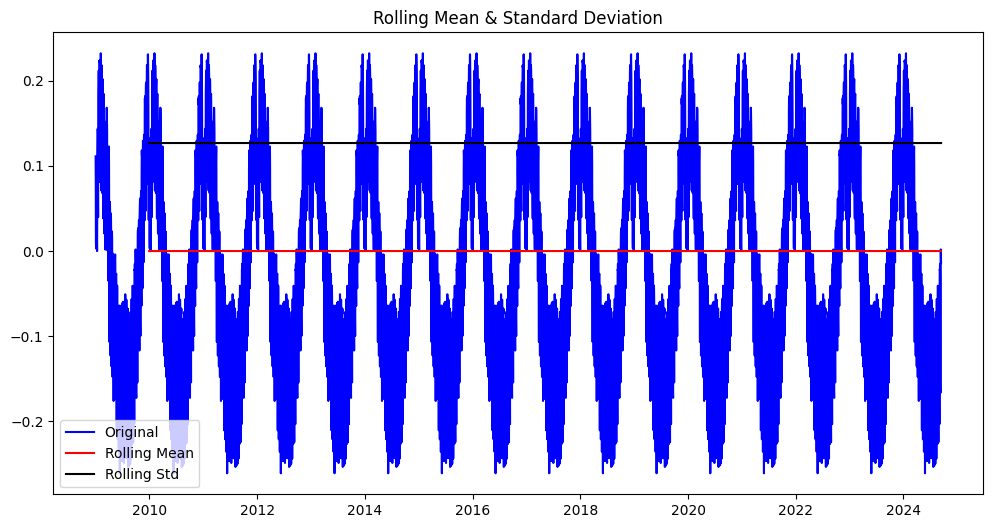

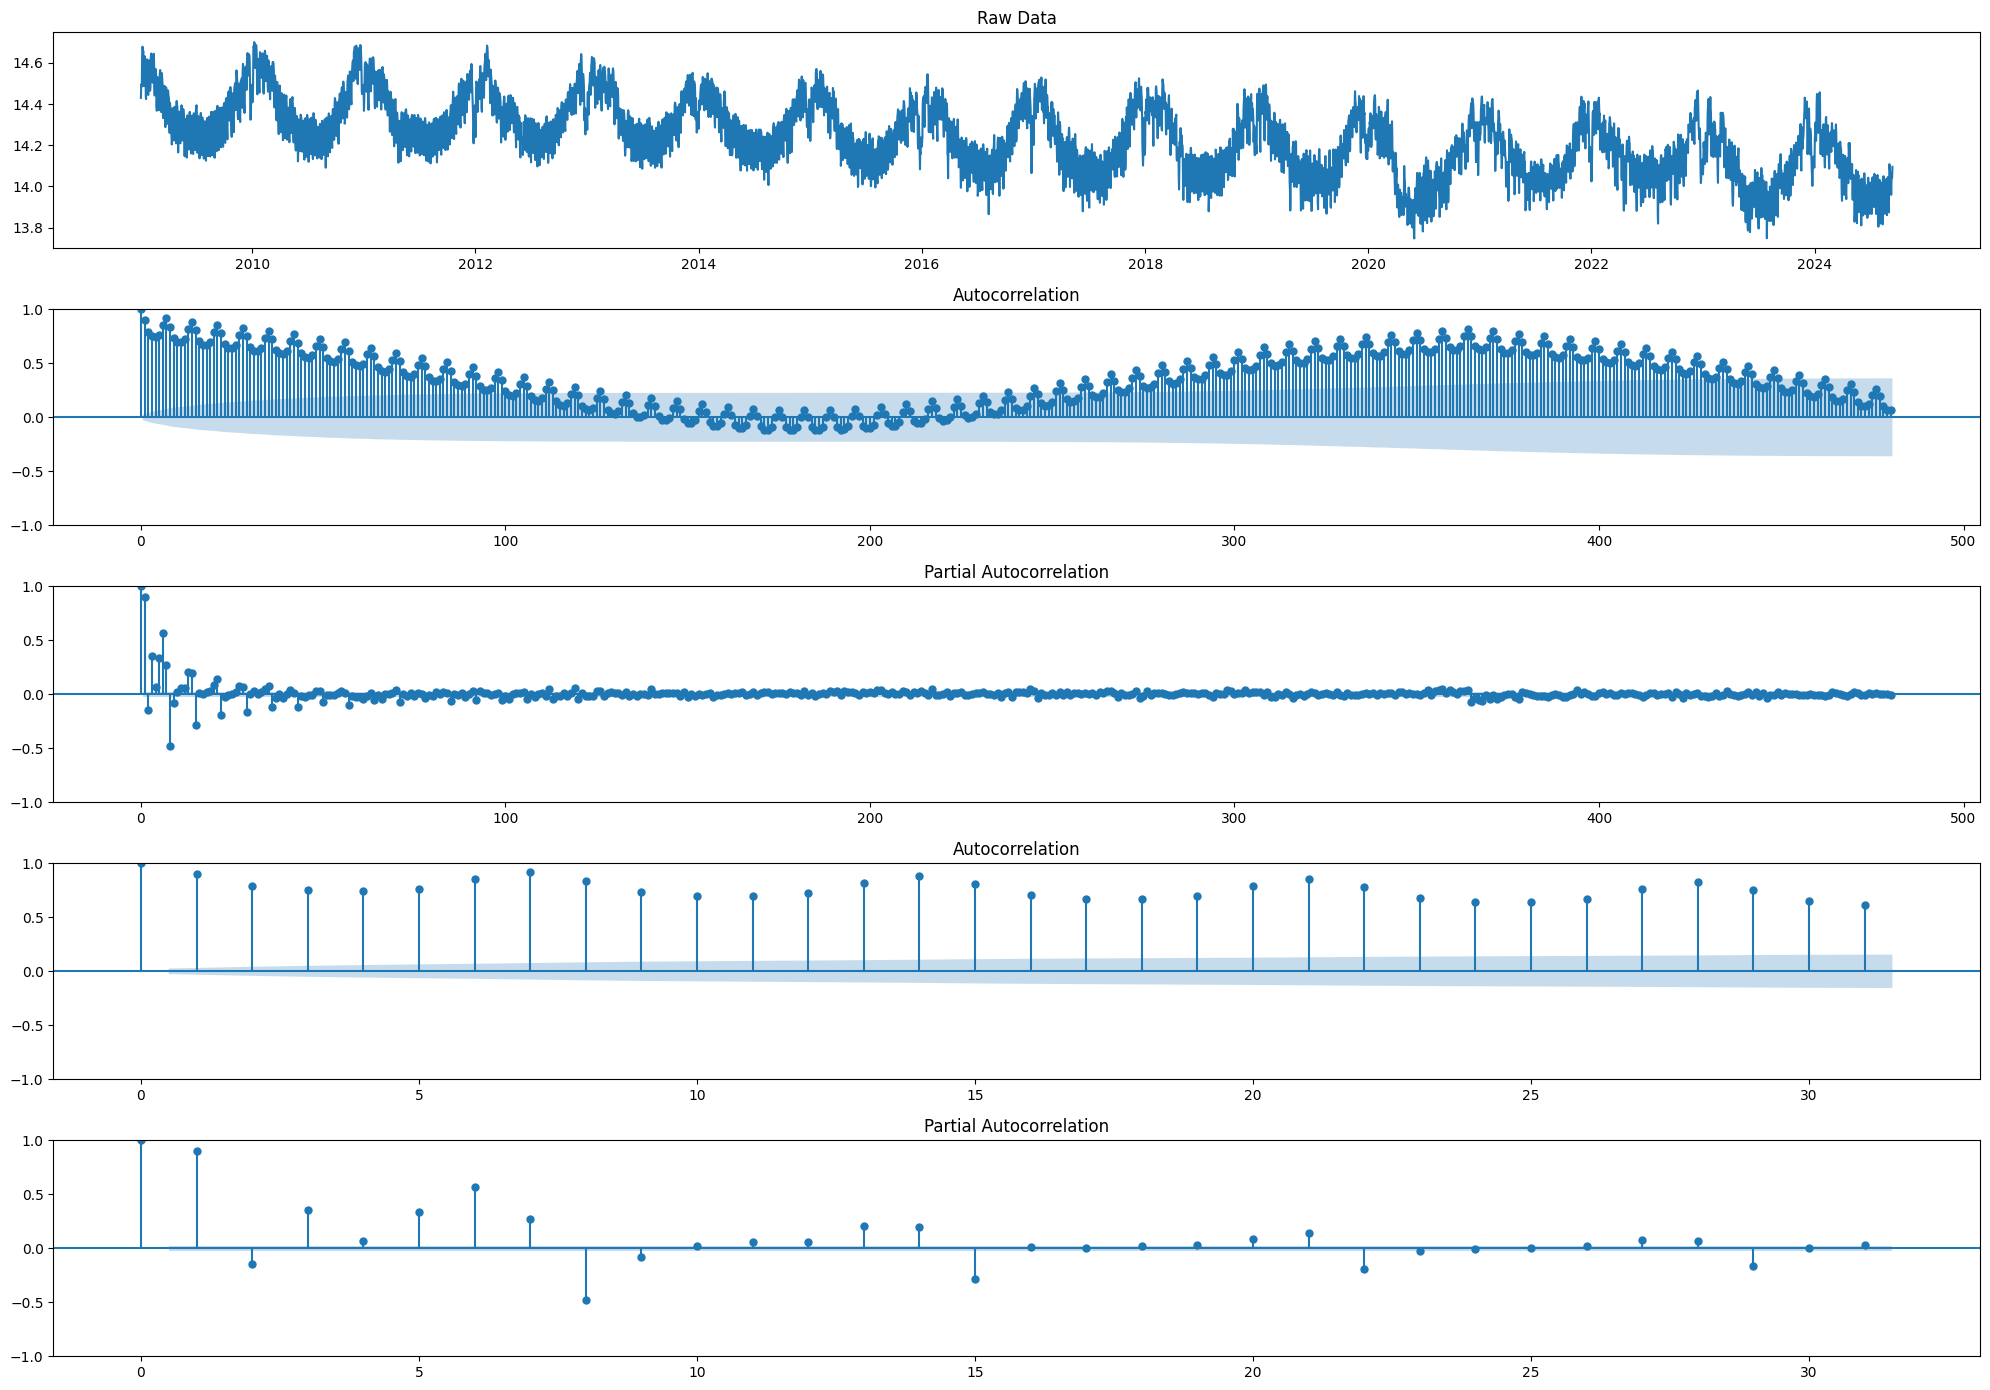

In [ ]:
# Assuming 'decompose' is already defined and contains seasonal decomposition results
dftest(decompose.seasonal, 364)

# Assuming 'df_sarima' is your DataFrame containing the 'tsd' time series data
autocorr_plots_dual_lags(df_sarima["log_tsd"], lags_1=480, lags_2=31)


 Splitting the Data

In [ ]:
threshold_date = "01-01-2022"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "log_tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "log_tsd"]


Building and Evaluating the SARIMA Model

In [ ]:


def create_predict_analyse(timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag):
       # Start timing the model fitting
    start_time = datetime.datetime.now()

    # Fit the SARIMA model
    model = sm.tsa.statespace.SARIMAX(timeseries,
                                      order=order,
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
    sarima_model = model.fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on the model
    print(sarima_model.summary())

    # Plot diagnostics
    sarima_model.plot_diagnostics(lags=lags, figsize=(15, 12))
    plt.show()

    # Predict on the test data
    pred = sarima_model.get_forecast(steps=len(test_data))
    pred_ci = pred.conf_int()
    predicted_values = pred.predicted_mean

    # Calculate the MAPE
    mape = mean_absolute_percentage_error(test_data, predicted_values)


    # Plot the predictions along with the confidence interval
    ax = test_data.plot(label='Observed')
    predicted_values.plot(ax=ax, label='Forecast', alpha=0.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.legend()
    plt.show()

    return execution_time, mape, sarima_model

                                     SARIMAX Results                                      
Dep. Variable:                            log_tsd   No. Observations:                 4748
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                5993.823
Date:                            Fri, 22 Nov 2024   AIC                         -11977.646
Time:                                    01:14:47   BIC                         -11945.333
Sample:                                01-01-2009   HQIC                        -11966.289
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   4.71e-05   2.12e+04      0.000       1.000       1.000
ma.L1          0.0448      0.020   

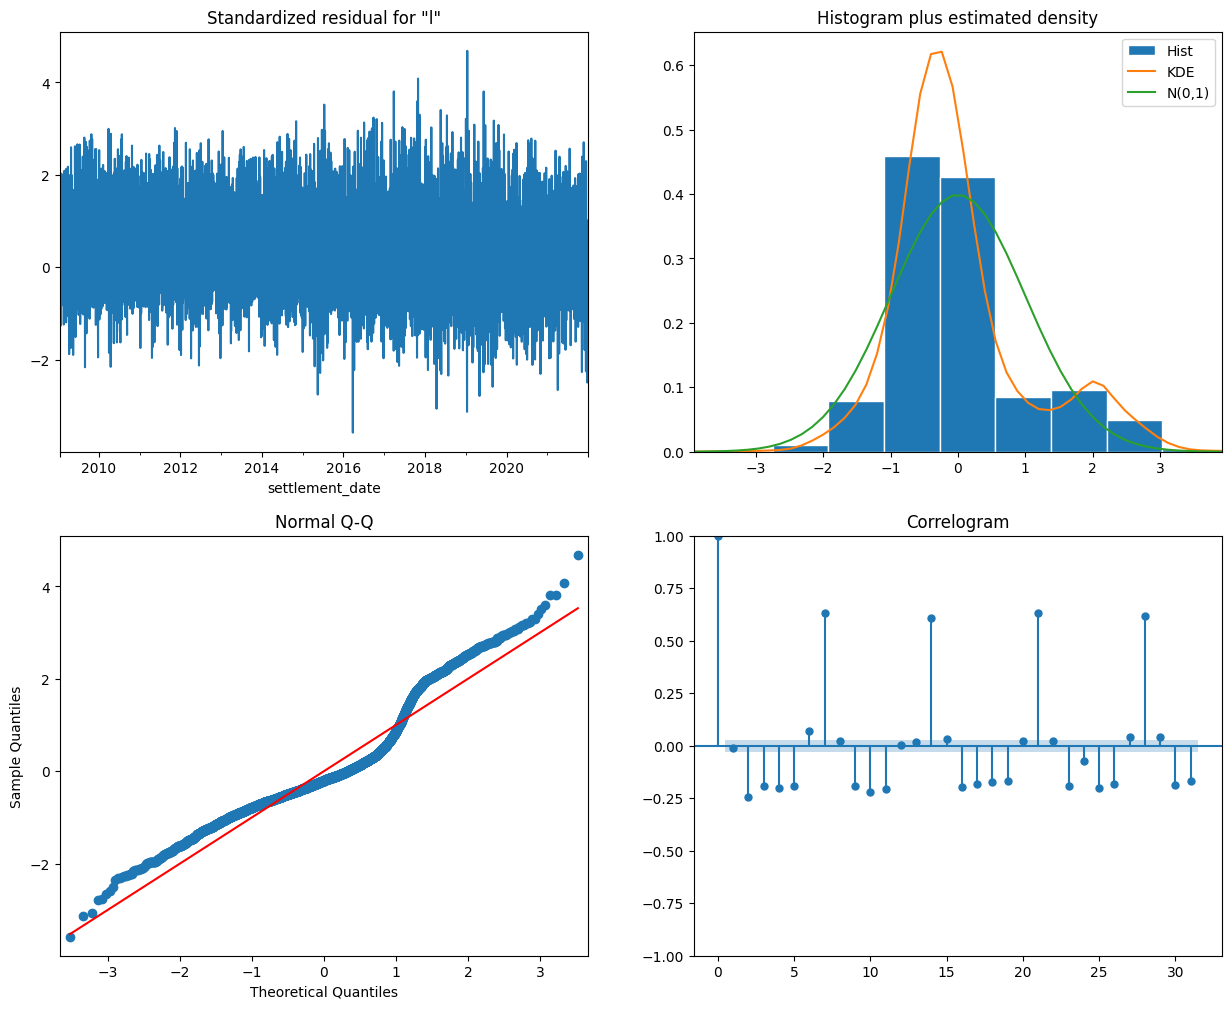

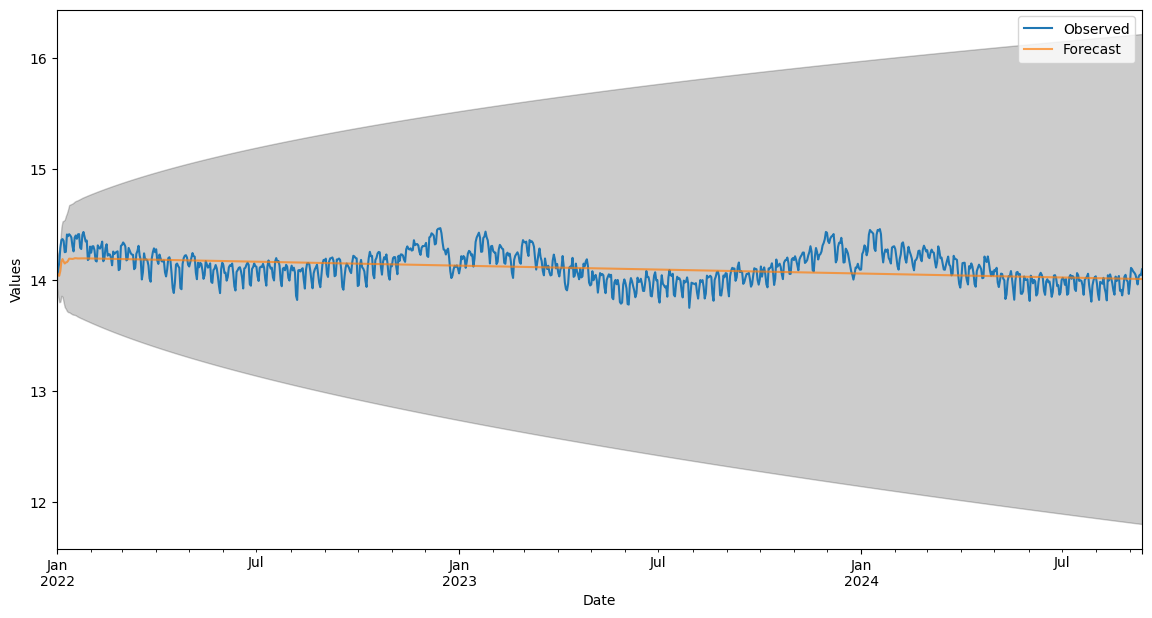

Model 0 MAPE value: 0.00760524103782144
Model 0 runtime: 0:00:17.515546


In [ ]:
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

print(f"Model 0 MAPE value: {mape_0}")
print(f"Model 0 runtime: {execution_time_0}")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            log_tsd   No. Observations:                 4748
Model:             SARIMAX(7, 1, 2)x(3, 1, 2, 12)   Log Likelihood                8077.818
Date:                            Fri, 22 Nov 2024   AIC                         -16125.635
Time:                                    01:18:54   BIC                         -16028.831
Sample:                                01-01-2009   HQIC                        -16091.597
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2066      0.029     -7.041      0.000      -0.264      -0.149
ar.L2         -0.3874      0.030   

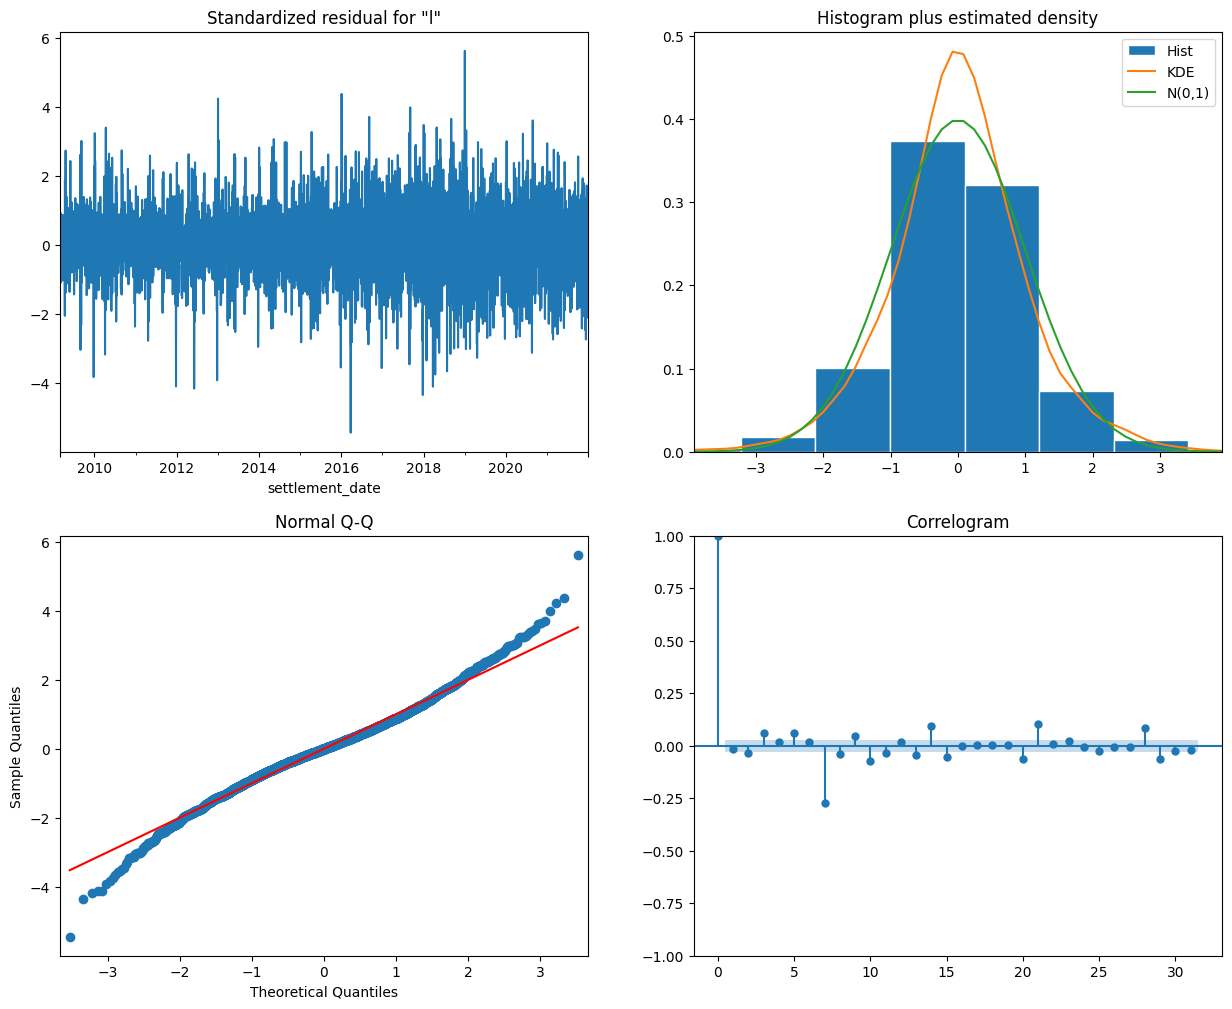

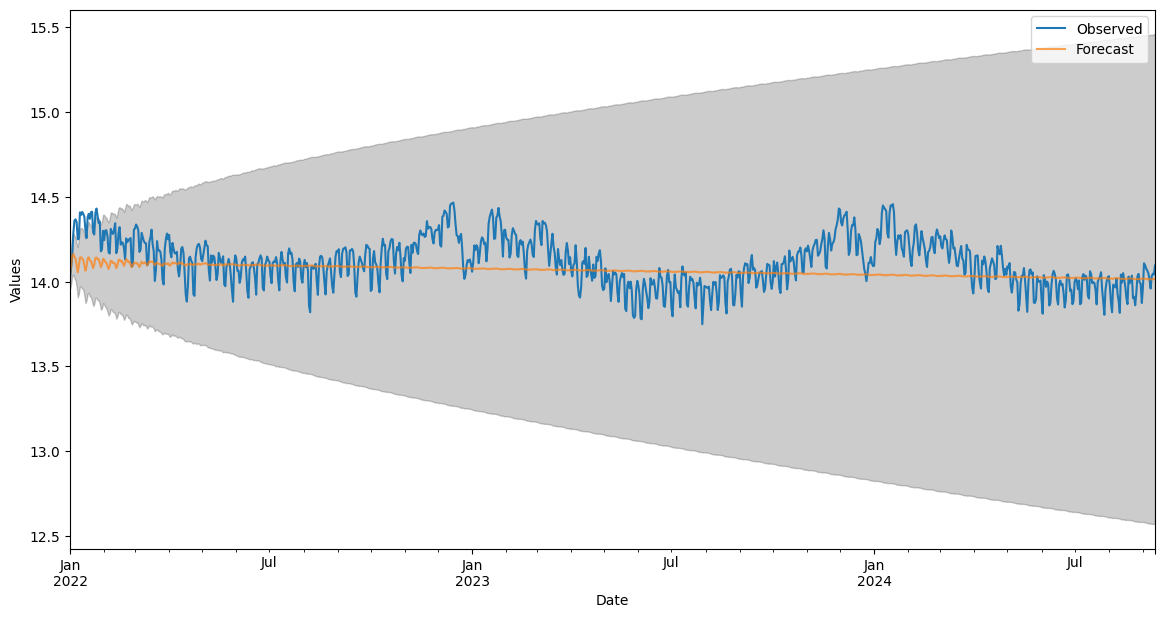

Model 1 MAPE value: 0.00803743966824225
Model 1 runtime: 0:03:52.505086


In [ ]:
[execution_time_1, mape_1, sarima_model_1] = create_predict_analyse(
    train_data, (7, 1, 2), (3, 1, 2, 12), 50, 31, test_data, False
)

print(f"Model 1 MAPE value: {mape_1}")
print(f"Model 1 runtime: {execution_time_1}")




Model 2



/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                 log_tsd   No. Observations:                 4748
Model:             SARIMAX(7, 1, 7)x(3, 1, [1, 2], 12)   Log Likelihood                8127.245
Date:                                 Fri, 22 Nov 2024   AIC                         -16214.489
Time:                                         01:22:06   BIC                         -16085.417
Sample:                                     01-01-2009   HQIC                        -16169.105
                                          - 12-31-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0278      0.023      1.187      0.235      -0.018       0

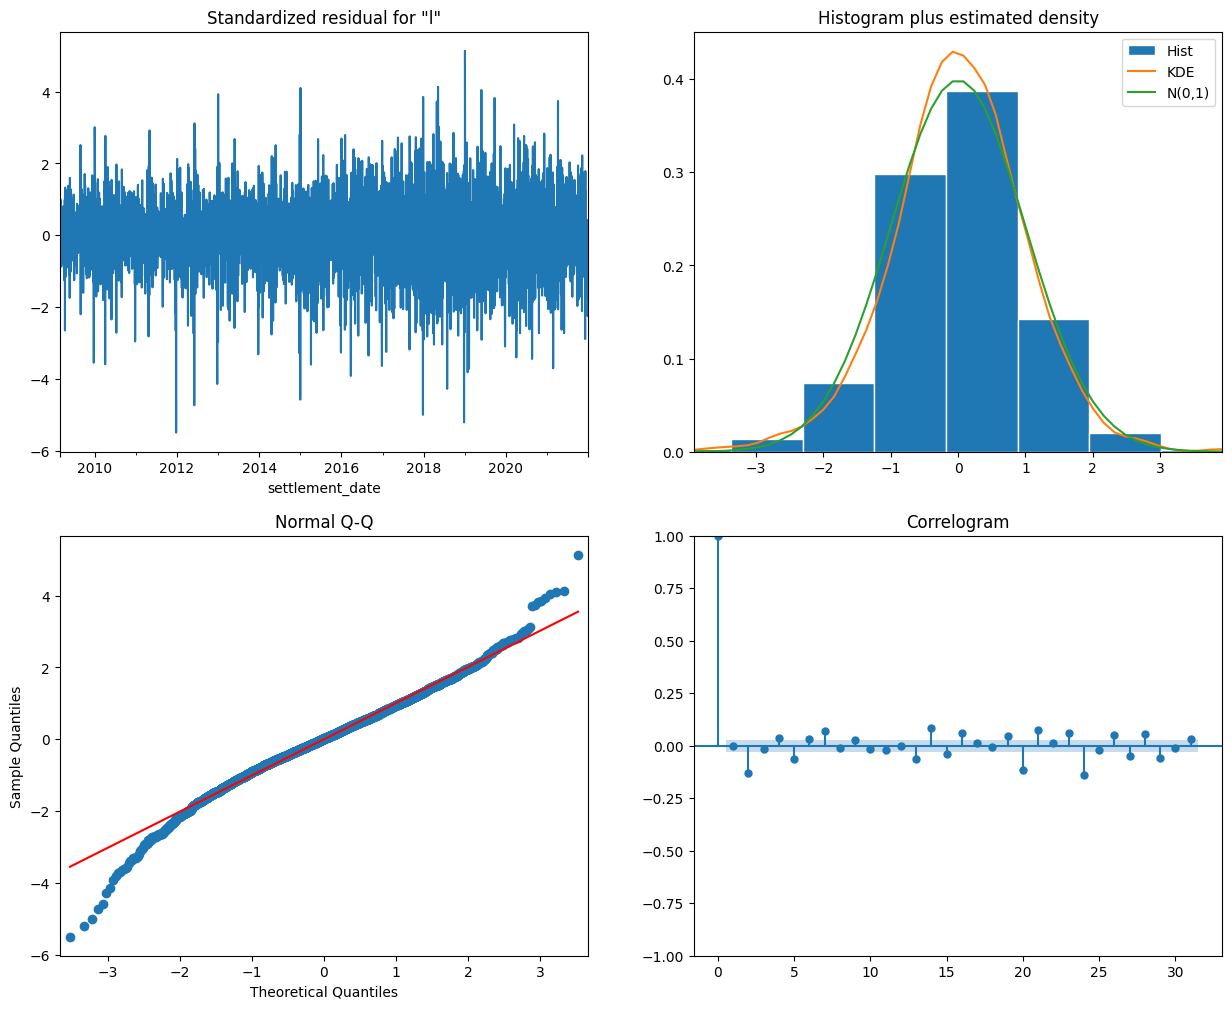

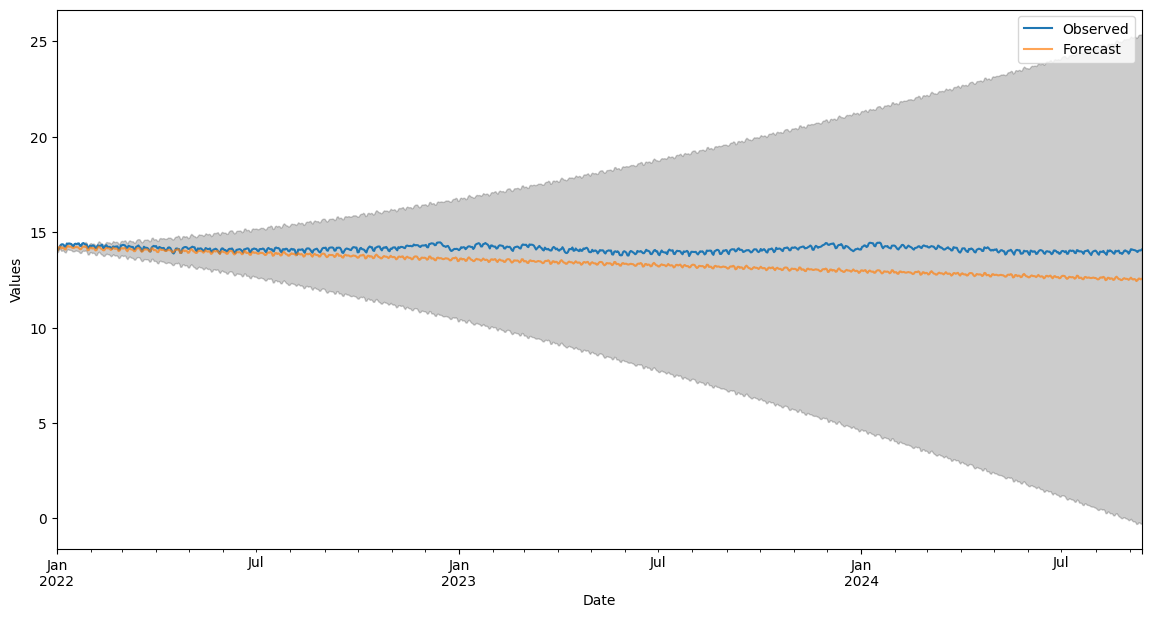

Model 2 MAPE value: 0.05321825623577423
Model 2 runtime: 0:02:58.133152


In [ ]:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train_data, (7, 1, 7), (3, 1, 2, 12), 50, 31, test_data, False
)

print(f"Model 2 MAPE value: {mape_2}")
print(f"Model 2 runtime: {execution_time_2}")


--------------